## NN

In [8]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import DataLoader
from torch.utils.data import random_split
torch.manual_seed(0)

from sklearn.metrics import accuracy_score
import sklearn.datasets
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [3]:
### Define dataloader

In [4]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len__(self):
        return self.y.size()[0]

In [5]:
data = pd.read_csv("final_validated_data.csv")
data.head()

,Unnamed: 0,RowID,maxsal,minsal,intern_num,month_num,day,industry,city,scale,...,招聘,媒体,内容,专员,产品,销售,开发,工程师,助理,运营
0,0,0,100,50,62,3,5,互联网/游戏/软件,北京,2000人以上,...,0,1,0,0,0,0,0,0,0,0
1,1,1,150,100,5,4,5,教育/培训,深圳,15-50人,...,0,0,0,0,0,0,0,0,0,0
2,2,2,300,250,8,4,5,互联网/游戏/软件,上海,15-50人,...,0,0,0,0,0,0,0,0,0,0
3,3,3,100,100,3,4,4,教育/培训,上海,15-50人,...,0,0,0,0,0,0,0,0,0,0
4,4,4,150,100,176,3,4,互联网/游戏/软件,广州,2000人以上,...,0,0,0,0,1,0,0,0,0,1


[Text(0, 0.5, 'Number of Data'), Text(0.5, 0, 'Class')]

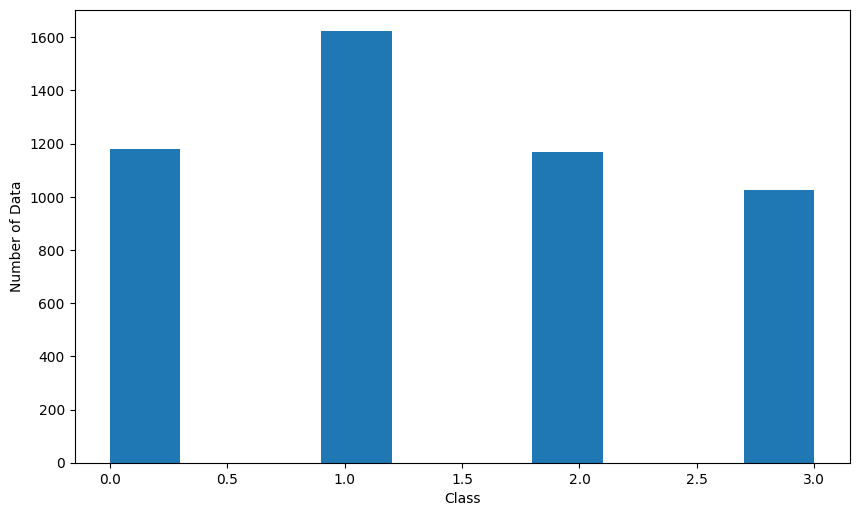

In [137]:

IT_df = data.drop(['Unnamed: 0', 'RowID', 'maxsal', 'minsal','industry', 'city', 'scale', 'name', 'uuid', 'c_desc', 'c_tag','c_name'],axis=1)

# #确定 X和 y

X = IT_df

# Label the max salary (4 classes)
label = []
max_sal = data["maxsal"].to_numpy()
for i in max_sal:

    if i in range(0,150):
        label.append(0)
    elif i in range(150,175):
        label.append(1)
    elif i in range(175,250):
        label.append(2)
    else:
        label.append(3)
y = np.array(label)
fig = plt.figure(figsize = (10,6), dpi = 100)
plt.hist(y)
plt.gca().set(
            xlabel = "Class",
            ylabel = "Number of Data" 
        )

(array([ 948., 1285.,  954.,  811.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

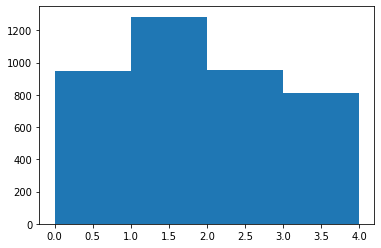

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=123)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_tensor_train = torch.from_numpy(np.asarray(X_train_scaled)).float()
y_tensor_train = torch.from_numpy(y_train)
train_set = MyDataset(X_tensor_train, y_tensor_train)

X_tensor_test = torch.from_numpy(np.asarray(X_test_scaled)).float()
y_tensor_test = torch.from_numpy(y_test)
test_set = MyDataset(X_tensor_test, y_tensor_test)

plt.hist(y_train, bins=[0,1,2,3,4])

In [30]:
inputDim = X.shape[1]
outputDim = 4

class logisticRegression(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(logisticRegression, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
#         self.layer4 = nn.Linear(hidden_size, hidden_size)
#         self.layer5 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
#         x = F.relu(x)
#         x = self.layer4(x)
#         x = F.relu(x)
#         x = self.layer5(x)
        return x
    
# model = logisticRegression(
#     input_size  = X_tensor.shape[1], 
#     hidden_size = ,
#     output_size = 4
# )
    
model = logisticRegression(inputDim, 64, outputDim)
dataloader = DataLoader(train_set, batch_size = 50, shuffle = True)
learningRate = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)
# ================分割线================
epochs = 100

test_acc_history = []
test_loss = []
train_history = []

for epoch in range(epochs):
    losses = []
    train_accuracy = []
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        losses.append(loss.item())
        train_accuracy.append(accuracy_score(y_batch, np.argmax(output.detach().numpy(), axis = 1)))
        
        optimizer.step()
    
    print('epoch {}, loss {}, train accuracy {}'.format(epoch, np.mean(losses), np.mean(train_accuracy)))
    train_history.append(np.mean(train_accuracy))
    
    if epoch >= 0:
        with torch.no_grad():
            out_test = model(x_test)
            test_accuracy = accuracy_score(np.argmax(out_test.numpy(), axis=1), y_test)
            loss = criterion(out_test, y_test)
        print("Test accuracy: {}, Test loss: {}".format(test_accuracy, loss.numpy()))
        test_acc_history.append(test_accuracy)
        test_loss.append(loss)

epoch 0, loss 1.3639182880520822, train accuracy 0.31616666666666665
Test accuracy: 0.336, Test loss: 1.333184838294983
epoch 1, loss 1.2783119842410087, train accuracy 0.40720833333333334
Test accuracy: 0.438, Test loss: 1.2626733779907227
epoch 2, loss 1.2300421372056007, train accuracy 0.42387499999999995
Test accuracy: 0.436, Test loss: 1.2427879571914673
epoch 3, loss 1.2041958257555962, train accuracy 0.44247916666666665
Test accuracy: 0.432, Test loss: 1.2372453212738037
epoch 4, loss 1.1873602792620659, train accuracy 0.45146875
Test accuracy: 0.446, Test loss: 1.2309759855270386
epoch 5, loss 1.171370267868042, train accuracy 0.4609375
Test accuracy: 0.459, Test loss: 1.2269971370697021
epoch 6, loss 1.1576195165514946, train accuracy 0.4702395833333333
Test accuracy: 0.446, Test loss: 1.220659613609314
epoch 7, loss 1.143388143181801, train accuracy 0.4804583333333333
Test accuracy: 0.443, Test loss: 1.2208675146102905
epoch 8, loss 1.132126259803772, train accuracy 0.4865000

epoch 70, loss 0.7904944255948066, train accuracy 0.6620729166666666
Test accuracy: 0.425, Test loss: 1.4998897314071655
epoch 71, loss 0.7867303036153317, train accuracy 0.6560520833333333
Test accuracy: 0.442, Test loss: 1.4976649284362793
epoch 72, loss 0.7901044115424156, train accuracy 0.6564062500000001
Test accuracy: 0.431, Test loss: 1.5411791801452637
epoch 73, loss 0.7929576098918915, train accuracy 0.6595625
Test accuracy: 0.438, Test loss: 1.489052653312683
epoch 74, loss 0.7816812627017498, train accuracy 0.6610416666666666
Test accuracy: 0.429, Test loss: 1.511448621749878
epoch 75, loss 0.7844320617616176, train accuracy 0.6613541666666667
Test accuracy: 0.423, Test loss: 1.5283457040786743
epoch 76, loss 0.7749117068946362, train accuracy 0.662625
Test accuracy: 0.432, Test loss: 1.5161917209625244
epoch 77, loss 0.7705265834927559, train accuracy 0.6673229166666667
Test accuracy: 0.424, Test loss: 1.5266414880752563
epoch 78, loss 0.7750807762145996, train accuracy 0.6

In [31]:
x_test, y_test = test_set[:]

with torch.no_grad():
    out_test = model(x_test)
    test_accuracy = accuracy_score(np.argmax(out_test.numpy(), axis=1), y_test)
    loss = criterion(out_test, y_test)
print("Test accuracy: {}, Test loss: {}".format(test_accuracy, loss.numpy()))

Test accuracy: 0.433, Test loss: 1.6468966007232666


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epochs')]

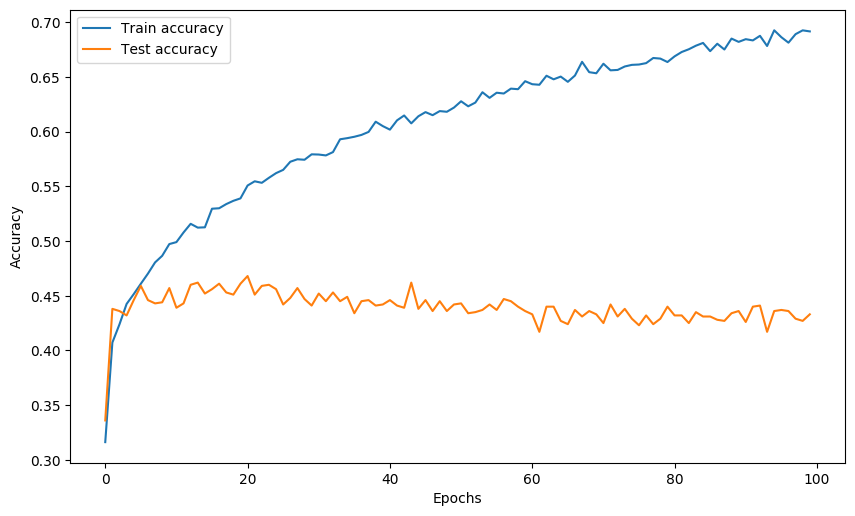

In [35]:
fig = plt.figure(figsize = (10,6), dpi = 100)
plt.plot(train_history, label = "Train accuracy")
plt.plot(test_acc_history, label = "Test accuracy")
plt.legend()
plt.gca().set(
            xlabel = "Epochs",
            ylabel = "Accuracy" 
        )

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epochs')]

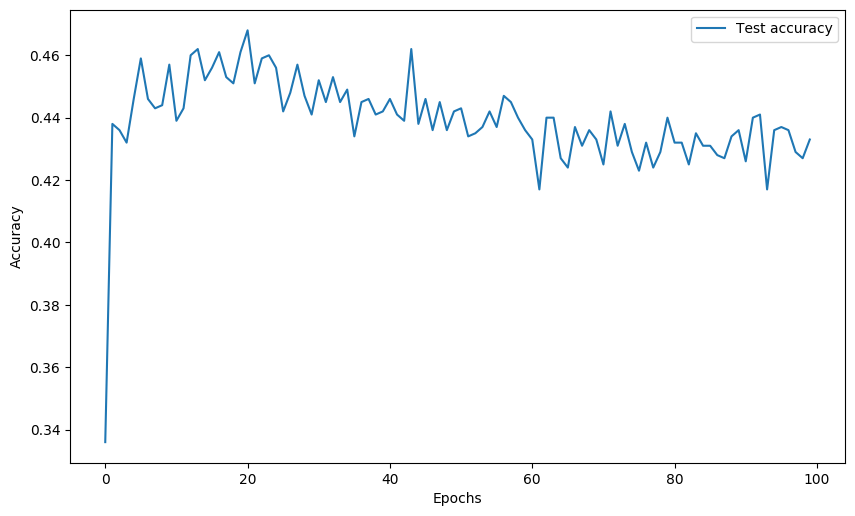

In [37]:
fig = plt.figure(figsize = (10,6), dpi = 100)
plt.plot(test_acc_history, label = "Test accuracy")
plt.legend()
plt.gca().set(
            xlabel = "Epochs",
            ylabel = "Accuracy" 
        )

In [135]:
test_acc_history

[0.336,
 0.438,
 0.436,
 0.432,
 0.446,
 0.459,
 0.446,
 0.443,
 0.444,
 0.457,
 0.439,
 0.443,
 0.46,
 0.462,
 0.452,
 0.456,
 0.461,
 0.453,
 0.451,
 0.461,
 0.468,
 0.451,
 0.459,
 0.46,
 0.456,
 0.442,
 0.448,
 0.457,
 0.447,
 0.441,
 0.452,
 0.445,
 0.453,
 0.445,
 0.449,
 0.434,
 0.445,
 0.446,
 0.441,
 0.442,
 0.446,
 0.441,
 0.439,
 0.462,
 0.438,
 0.446,
 0.436,
 0.445,
 0.436,
 0.442,
 0.443,
 0.434,
 0.435,
 0.437,
 0.442,
 0.437,
 0.447,
 0.445,
 0.44,
 0.436,
 0.433,
 0.417,
 0.44,
 0.44,
 0.427,
 0.424,
 0.437,
 0.431,
 0.436,
 0.433,
 0.425,
 0.442,
 0.431,
 0.438,
 0.429,
 0.423,
 0.432,
 0.424,
 0.429,
 0.44,
 0.432,
 0.432,
 0.425,
 0.435,
 0.431,
 0.431,
 0.428,
 0.427,
 0.434,
 0.436,
 0.426,
 0.44,
 0.441,
 0.417,
 0.436,
 0.437,
 0.436,
 0.429,
 0.427,
 0.433]

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

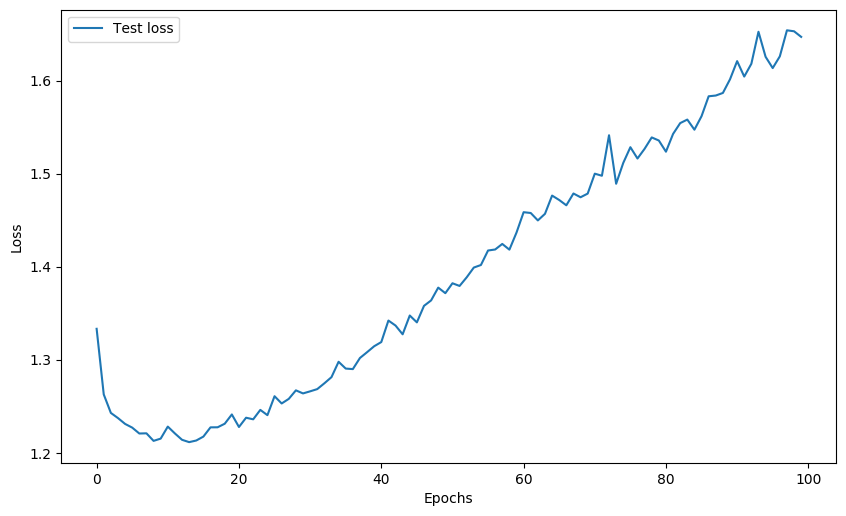

In [38]:
fig = plt.figure(figsize = (10,6), dpi = 100)
plt.plot(test_loss, label = "Test loss")
plt.legend()
plt.gca().set(
            xlabel = "Epochs",
            ylabel = "Loss" 
        )

In [50]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2038,  0.1084,  0.2191,  ..., -0.2108, -0.0724, -0.0364],
         [ 0.0551,  0.1363,  0.0874,  ...,  0.0685,  0.2064, -0.1387],
         [ 0.1787,  0.0840,  0.0182,  ..., -0.2897, -0.0301, -0.2371],
         ...,
         [-0.2525,  0.4321, -0.1737,  ..., -0.0224, -0.4160, -0.0831],
         [ 0.2213,  0.0814, -0.2158,  ..., -0.4806,  0.2338, -0.2265],
         [-0.6246,  0.1315, -0.2096,  ...,  0.0788, -0.3871, -0.0776]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0334,  0.0194,  0.1130,  0.1374,  0.1418,  0.0295, -0.0039,  0.2127,
          0.0073,  0.0578,  0.1630,  0.0965,  0.1611,  0.1039, -0.0294, -0.1298,
         -0.0291,  0.0274,  0.1072, -0.1143,  0.1387, -0.1333,  0.0827, -0.1456,
         -0.0490, -0.0965,  0.0747, -0.0230, -0.1207,  0.0571,  0.0730,  0.1526,
         -0.0472,  0.0595, -0.0809, -0.0201,  0.0816, -0.0152, -0.0452,  0.0276,
         -0.0129,  0.1458,  0.0460,  0.0294,  0.0899,  0.1173,  0.0501, -0.1132

In [79]:
y_pred_1 = model(torch.from_numpy(np.asarray(X_train_scaled)).float())
y_pred_1
prediction = torch.argmax(y_pred_1, dim=1)
prediction

tensor([1, 0, 2,  ..., 2, 2, 2])

In [105]:
type(model)
y_pred = mode

__main__.logisticRegression

In [85]:
prediction.numpy()

array([1, 0, 2, ..., 2, 2, 2])

In [84]:
# plt.hist(prediction.numpy())

In [128]:
svm_model = svm.SVC(decision_function_shape = 'ovo', kernel = 'rbf', C = 1, gamma = 0.5)
svm_model.fit(X_train_scaled, y_train)

tree_model = DecisionTreeClassifier(max_depth = 30,  max_leaf_nodes = 1000, min_samples_split = 2, min_samples_leaf = 10)
tree_model.fit(X_train_scaled, y_train)




DecisionTreeClassifier(max_depth=30, max_leaf_nodes=1000, min_samples_leaf=10)

In [133]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression

class StackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self._svm = svm_model
        self._decision_tree = tree_model
        self._NN = model
        self._logistic = LogisticRegression()
    
    
    def base_model_pred(self,X):
        svm_pred = self._svm.predict(X)
        tree_pred = self._decision_tree.predict(X)
        NN_pred = self._NN(torch.FloatTensor(X))
        final_x = np.hstack((svm_pred,tree_pred,NN_pred))
        return final_x
        
        
    def fit(self,X,y):
        base_model_pred = self.base_model_pred(X)
        self._logistic.fit(base_model_pred,y)
    
    
    
    def predict(self,X):
        
        base_model_pred = self.base_model_pred(X)
        
        return self._logistic.predict(base_model_pred)
        
        

In [134]:
from sklearn.model_selection import cross_val_score

stackclassifier = StackingClassifier()

scores = cross_val_score(stackclassifier, X_train_scaled, y_train, cv=5)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-133-ee5884797098>", line 21, in fit
    base_model_pred = self.base_model_pred(X)
  File "<ipython-input-133-ee5884797098>", line 16, in base_model_pred
    final_x = np.hstack((svm_pred,tree_pred,NN_pred))
  File "<__array_function__ internals>", line 5, in hstack
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/shape_base.py", line 338, in hstack
    arrs = atleast_1d(*tup)
  File "<__array_function__ internals>", line 5, in atleas

In [118]:

NN = NNClassifier(model=model)
print(type(model))

<class '__main__.logisticRegression'>


In [119]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


estimators = [
    ('knn', KNeighborsClassifier(10)),
    ('dt', DecisionTreeClassifier(max_depth = 30,  max_leaf_nodes = 1000, min_samples_split = 2, 
                                  min_samples_leaf = 10)),
#     ('rf', RandomForestClassifier(max_depth = 30,  max_leaf_nodes = 1000, min_samples_split = 2, 
#                                   min_samples_leaf = 10, n_estimators = 40)),
    ('svm', svm.SVC(decision_function_shape = 'ovo', kernel = 'rbf', C = 1, gamma = 0.5)),
    ('nn', NN)
     
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [120]:
from sklearn.model_selection import train_test_split

clf.fit(X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


herere
herere
None


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


TypeError: 'NoneType' object is not callable